In [22]:
import natsort
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.signal as signal
import skimage.filters as filters
from IPython.display import display, clear_output
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from PIL import Image
#from pyneurotrace import filters  as pntfilters
from scipy import integrate
from scipy.stats import sem

<H3> Global Variables

In [23]:
# The Folder containing sub-directories to include in analysis
DATA_DIRECTORY = "Output_Traces"
# Frequency frames were collected
HZ = 10

In [24]:
"""
Jia, H., Rochefort, N. L., Chen, X., & Konnerth, A. (2011).
In vivo two-photon imaging of sensory-evoked dendritic calcium signals in cortical neurons.
Nature protocols, 6(1), 28.
"""
"""
Podgorski, K., & Haas, K. (2013).
Fast non‐negative temporal deconvolution for laser scanning microscopy.
Journal of biophotonics, 6(2), 153-162.
"""
"""
Coleman, P. (2019).
pyNeuroTrace. https://github.com/padster/pyNeuroTrace.git
"""
# To install pyneuortrace use this:
# pip install --upgrade "git+https://github.com/padster/pyNeuroTrace#egg=pyneurotrace&subdirectory=pyneurotrace"

'\nColeman, P. (2019).\npyNeuroTrace. https://github.com/padster/pyNeuroTrace.git\n'

In [25]:
# Change output figure size
# ...needs to be in its own cell for some reason...

plt.rcParams['figure.figsize'] = [20, 5]

In [26]:
"""
Performs fast nonnegative deconvolution on pmt signal to solve for minimum MSE photon rate
   trace  :   The data to be deconvolved
   tau    :   The time constant of the PMT, in data samples
   return :   estimated photon rate
A matlab version is also available on request.
For details on how this works, see:
  Podgorski, K., & Haas, K. (2013).
  Fast non‐negative temporal deconvolution for laser scanning microscopy.
  Journal of biophotonics, 6(2), 153-162.
"""
def nonNegativeDeconvolution(trace, tau):
    T = len(trace)
    counts = np.zeros(T)
    counts[-1] = trace[-1]
    cutoff = math.ceil(8 * tau)
    kernel = np.exp(-np.arange(cutoff + 1)/tau) # convolution kernel
    recent = np.full(1 + round(T / 2), np.nan).astype(int)
    recent[0] = T #stored locations where we assigned counts
    recentIdx = 0

    # the points that could potentially be assigned counts:
    _delayed = np.concatenate(([0], trace[:-2]))
    points = (trace[:-1] > kernel[1] * _delayed) & (trace[:-1] > 0)

    # dividing these points up into runs, for speed
    runStarts = np.where(points & ~(np.concatenate(([False], points[:-1]))))[0].astype(int)
    runEnds = np.where(points & ~(np.concatenate((points[1:], [False]))))[0].astype(int)
    runIdx = len(runEnds) - 1

    while runIdx >= 0:
        oldTop, oldBottom = 0, 0
        t = runEnds[runIdx]
        t1 = t
        accum = 0

        converged = False
        while not converged:
            if recentIdx >= 0 and recent[recentIdx] < (t+cutoff):
                t2 = recent[recentIdx] - 1
                C_max = counts[t2] / kernel[t2-t]
            else:
                t2 = min(t + cutoff, T+1) - 1
                C_max = np.inf


            b = kernel[t1-t:t2-t]
            top = np.dot(b, trace[t1:t2]) + oldTop #this is the numerator of the least squares fit for an exponential
            bottom = np.dot(b, b) + oldBottom #this is the denominator of the fit

            done = False
            while not done:
                #the error function is (data-kernel.*C)^2
                bestC = max(top/bottom, 0);  #C=top/bottom sets the derivative of the error to 0

                # does not meet nonnegative constraint. Continue to adjust previous solutions.
                if bestC > (C_max+accum):
                    accum = accum + counts[t2] / kernel[t2-t]
                    counts[t2] = 0
                    t1 = t2
                    oldTop = top
                    oldBottom = bottom
                    recentIdx -= 1
                    done = True

                else: # converged!
                    #now that we have found the MSE counts for times t<end, check if
                    #this will be swamped by the next timepoint in the run
                    if  (t == runStarts[runIdx]) or (trace[t-1] < bestC/kernel[1]): #%C_max won't necessarily get swamped
                        if recentIdx >= 0 and t2 <= t + cutoff:
                            counts[t2] = counts[t2] - (bestC - accum) * kernel[t2-t]
                        runStart = runStarts[runIdx]
                        initIdx = recentIdx + 1
                        recentIdx = recentIdx + 1 + t - runStart;

                        _skipped = 0
                        if recentIdx + 1 > len(recent):
                            _skipped = recentIdx - (len(recent) - 1)
                            recentIdx = len(recent) - 1


                        recent[initIdx:recentIdx + 1] = np.arange(t+1, runStart + _skipped, -1)
                        counts[runStart:(t+1)] = \
                               np.concatenate((trace[runStart:t], [bestC])) - \
                               np.concatenate(([0], kernel[1]*trace[runStart:t]))
                        done = True
                        converged = True
                    else: #%C_max will get swamped
                        #%in this situation, we know that this point will be removed
                        #%as we continue to process the run. To save time:
                        t -= 1
                        runEnds[runIdx] = t
                        accum = accum / kernel[1]
                        top = top * kernel[1] + trace[t] #% %this is the correct adjustment to the derivative term above
                        bottom = bottom * (kernel[1] ** 2) + 1 #% %this is the correct adjustment to the derivative term above

        runIdx -= 1
    return counts

In [27]:
def nndSmooth(data, hz, tau, iterFunc=None):
    tauSamples = tau * hz

    # This is the transient shape we're deconvolving against:
    # e^(x/tauSamples), for 8 times the length of tau.
    cutoff = round(8 * tauSamples)
    fitted = np.exp(-np.arange(cutoff + 1) / tauSamples)

    def _singleRowNND(samples):
        result = np.copy(samples)
        nanSamples = np.isnan(samples)
        if np.all(nanSamples):
            pass # No data
        elif not np.any(nanSamples):
            # All samples exist, so fit in one go
            result = np.convolve(nonNegativeDeconvolution(samples, tauSamples), fitted)[:len(samples)]
        else:
            # Lots of different runs of samples, fit each separately
            starts = np.where((not nanSamples) & np.isnan(np.concatenate(([1], samples[:-1]))))[0]
            ends = np.where((not nanSamples) & np.isnan(np.concatenate((samples[1:], [1]))))[0]
            for start, end in zip(starts, ends):
                tmp = np.convolve(NND(samples[start:end], tauSamples), fitted)
                result[start:end] = np.max(0, tmp[:end - start + 1])
        return result

    return _forEachTimeseries(data, _singleRowNND, iterFunc)

def deltaFOverF0(data, hz, t0=0.2, t1=0.75, t2=3.0, iterFunc=None):
    t0ratio = None if t0 is None else np.exp(-1 / (t0 * hz))
    t1samples, t2samples = round(t1 * hz), round(t2*hz)

    def _singeRowDeltaFOverF(samples):
        fBar = _windowFunc(np.mean, samples, t1samples, mid=True)
        f0 = _windowFunc(np.min, fBar, t2samples)
        result = (samples - f0) / f0
        if t0ratio is not None:
            result = _ewma(result, t0ratio)
        return result
    return _forEachTimeseries(data, _singeRowDeltaFOverF, iterFunc)


def _windowFunc(f, x, window, mid=False):
    n = len(x)
    startOffset = (window - 1) // 2 if mid else window - 1
    result = np.zeros(x.shape)
    for i in range(n):
        startIdx = i - startOffset
        endIdx = startIdx + window
        startIdx, endIdx = max(0, startIdx), min(endIdx, n)
        result[i] = f(x[startIdx:endIdx])
    return result


def _ewma(x, ratio):
    result = np.zeros(x.shape)
    weightedSum, sumOfWeights = 0.0, 0.0
    for i in range(len(x)):
        weightedSum = ratio * weightedSum + x[i]
        sumOfWeights = ratio * sumOfWeights + 1.0
        result[i] = weightedSum / sumOfWeights
    return result

# Input is either 1d (timeseries), 2d (each row is a timeseries) or 3d (x, y, timeseries)
def _forEachTimeseries(data, func, iterFunc=None):
    if iterFunc is None:
        iterFunc = lambda x: x
    dim = len(data.shape)
    result = np.zeros(data.shape)
    if dim == 1: # single timeseries
        result = func(data)
    elif dim == 2: # (node, timeseries)
        for i in iterFunc(range(data.shape[0])):
            result[i] = func(data[i])
    elif dim == 3: # (x, y, timeseries)
        for i in iterFunc(range(data.shape[0])):
            for j in iterFunc(range(data.shape[1])):
                result[i, j] = func(data[i, j])
    return result

In [28]:
def peakThreshold(trace):
    # Third Order Butterworth lowpass filter; 3hz cutoff
    # Finds the std of baseline signal to use as an amplitude threshold forpeak detections
    
    fc = 3  # Cut-off frequency of the filter
    w = fc / (10 / 2) # Normalize the frequency      
    b, a = signal.butter(3, w, 'low', analog=True)
    z = signal.lfilter(b, a, trace, axis=0)
    
    # Plots to show threshold and trace with Butterworth lowpass filter
    #plt.plot(trace, linewidth=2, color='Black')
    #plt.plot(z, linewidth=2, color='orange')
    #plt.hlines(np.std(z[:]), xmin=0, xmax=z.shape[0])
    #plt.show()
    
    
    # Detect Peaks
    threshold = np.std(z[:])
    return threshold

In [73]:
def peakDetect(trace, threshold_dic, key):
   
    # Detect Peaks
    threshold =threshold_dic[key[:11]]

    peaks, _ = signal.find_peaks(trace, width=7, rel_height=.5, prominence=(threshold))

    width = signal.peak_widths(trace, peaks, rel_height=.5)
    
    width10 = signal.peak_widths(trace, peaks, rel_height=.9)
    return peaks, width[0], width10[0]

def signal_analysis(cell_id, gcamp, rcamp, rawG, rawR, thresholdG, thresholdR):
    print(cell[:cell.find('_Soma')])
    str_index = int(cell_id.find("Iono_"))
    threshold_cuttoff = gcamp.shape[0]
    gcamp_peaks, gcamp_widths, gcamp_widths10 = peakDetect(gcamp, thresholdG, cell_id)
    rcamp_peaks, rcamp_widths,rcamp_widths10 = peakDetect(rcamp, thresholdR, cell_id)


    drug_app = np.nan
    iono_min = [np.nan, np.nan]
    iono_max = [np.nan, np.nan]
    iono_diff = [np.nan, np.nan]
    
    # Update: Now uses value of drug app from folder name
    # Should return -1 is no match is found for the key string 'Iono_'
    if cell_id.find("Iono_") is not -1:
        str_index = int(cell_id.find("Iono_"))
        drug_app = (int(cell_id[(str_index+5):(str_index+8)])*HZ)
        cutoffG = np.array(np.where(gcamp_peaks >= drug_app)[0])
        if cutoffG.size !=0:
            cutoffG = np.min(cutoffG)
            
        if cutoffG != 0:

            if cutoffG.size !=0:
                cutoffG = np.min(cutoffG)

            cutoffR = np.array(np.where(rcamp_peaks >= drug_app))
            if cutoffR.size !=0:
                cutoffR = np.min(cutoffR)
 
            gcamp_peaks = gcamp_peaks[:cutoffG]
            gcamp_widths = gcamp_widths[:cutoffG]
            gcamp_widths10 = gcamp_widths10[:cutoffG]

            rcamp_peaks = rcamp_peaks[:cutoffR]
            rcamp_widths = rcamp_widths[:cutoffR]
            rcamp_widths10 = rcamp_widths10[:cutoffR]
  
  
    if cell_id.find("_S") is not -1:
        if drug_app is not np.nan:
            iono_min[0] = np.min(rawG[drug_app-200:drug_app+1000]>0)
            iono_min[1] = np.min(rawR[drug_app-200:drug_app+1000]>0)

            iono_max[0] = np.max(rawG[drug_app-200:drug_app+1000])
            iono_max[1] = np.max(rawR[drug_app-200:drug_app+1000])

            iono_diff[0] = iono_max[0]-iono_min[0]
            iono_diff[1] = iono_max[1]-iono_min[1]

    
    # Match Peaks and puttin them in a list of tuples (g, r)
    gcamp_matched = []
    shared_rcamp = []
    shared_gcamp = []
    for g in gcamp_peaks:
        for r in rcamp_peaks:
            a = math.isclose(g, r, abs_tol=15)
            if a == True:
                gcamp_matched.append((g,r))
                shared_rcamp.append(r)
                shared_gcamp.append(g)
    
    rcamp_only = list(set(rcamp_peaks)-set(shared_rcamp))
    rcamp_only.sort
    gcamp_only = list(set(gcamp_peaks)-set(shared_gcamp))
    gcamp_only.sort

    if len(gcamp_peaks) == 0:
        g_percent_shared = np.nan
    else:
        g_percent_shared = (len(gcamp_matched)/len(gcamp_peaks))
        
    if len(rcamp_peaks) == 0:
        r_percent_shared = np.nan
    else:
        r_percent_shared = (len(gcamp_matched)/len(rcamp_peaks))
    if len(gcamp_matched) == 0:
        r_percent_shared = np.nan
        g_percent_shared = np.nan

    # Integrate the area under each Traces
    int_rcamp = integrate.cumtrapz(rcamp)
    int_gcamp = integrate.cumtrapz(gcamp)
    # General Stats for the cell
    cell_stats = { 
                                'Cell ID': cell[:cell.find('_Soma')],
                                'GCaMP Peaks':len(gcamp_peaks),
                                'RCaMP Peaks':len(rcamp_peaks),
                                'Shared Peaks':len(gcamp_matched),
                                'GCaMP Percent Shared':g_percent_shared,
                                'RCaMP Percent Shared':r_percent_shared,
                                'Experiment Length (s)': gcamp.shape[0]/HZ,
                                'Drug Application': drug_app/HZ,
                                'Iono GCaMP Max': iono_max[0],
                                'Iono GCaMP Dif': iono_diff[0],
                                'Iono RCaMP Max': iono_max[1],
                                'Iono RCaMP Dif': iono_diff[1],
                                'RCaMP Total Area': int_rcamp[-1],
                                'GCaMP Total Area': int_gcamp[-1]

                                
                               }
    
    cell_stats = pd.DataFrame(data=cell_stats, index=[0])
    
    # Peak Data for Shared Peaks
    shared_peak_data = pd.DataFrame()
    for event in gcamp_matched:
        
        gindex = np.where(gcamp_peaks == event[0])[0]
        rindex = np.where(rcamp_peaks == event[1])[0]
        
        
        # Integrate Under the Curve for Area 
        # Note: Area from start to peak
        g_event_start = int(event[0]-gcamp_widths[gindex])
        if g_event_start < 0: 
            g_event_start = 0
        r_event_start = int(event[0]-rcamp_widths[rindex])
        if r_event_start < 0:
            r_event_start = 0

        g_area = integrate.cumtrapz(gcamp[g_event_start:event[0]])
        if len(g_area) is not 0:
            g_area = g_area[-1]
        r_area = integrate.cumtrapz(rcamp[r_event_start:event[1]])
        if len(r_area) is not 0:
            r_area = r_area[-1]
        
        peak_stats = {          'Cell ID': cell[:cell.find('_Soma')],            
                                'Soma Loc':event[0],
                                'Soma Start': event[0]-gcamp_widths[gindex][0]*HZ,
                                'Soma Width':gcamp_widths[gindex][0],
                                'Soma Prominence':gcamp[event[0]],
                                'Soma Area':g_area,                                
                                'Dendrites Loc':event[1],
                                'Dendrites Start': event[1]-rcamp_widths[rindex][0]*HZ,
                                'Dendrites Width':rcamp_widths[rindex][0],
                                'Dendrites Prominence':rcamp[event[1]],
                                'Dendrites Area':r_area,                                
                                'Promicence Ratio (S/D)':(gcamp[event[1]]/rcamp[event[0]]),
                                'Peak Time Diff (S-D)':((event[0]-event[1])*100),
                                'Start Difference (S-D)': ((event[0]-gcamp_widths[gindex]) - (event[1]-rcamp_widths[rindex]))[0]*(1/HZ),
                                'Soma Start 10% Max': event[0]-gcamp_widths10[gindex][0]*HZ, 
                                'Dendrites Start  10% Max': event[1]-rcamp_widths10[rindex][0]*HZ, 
                                'Start Difference (S-D)  10% Max': ((event[0]-gcamp_widths10[gindex]) - (event[1]-rcamp_widths10[rindex]))[0]*(1/HZ)

                                                                 }
        shared_peak_data = shared_peak_data.append(peak_stats, ignore_index=True)
    
    # Adding RCaMP peaks to the shared datatable
    for event in rcamp_only:
        
        rindex = np.where(rcamp_peaks == event)[0]
        
        
        # Integrate Under the Curve for Area 
        # Note: Area from start to peak
        r_event_start = int(event-rcamp_widths[rindex])
        if r_event_start < 0:
            r_event_start = 0

        r_area = integrate.cumtrapz(rcamp[r_event_start:event])
        if len(r_area) is not 0:
            r_area = r_area[-1]
        
        peak_stats = {          'Cell ID': cell[:cell.find('_Soma')],              
                                'Soma Loc':np.nan,
                                'Soma Start': np.nan,
                                'Soma Width':np.nan,
                                'Soma Prominence':np.nan,
                                'Soma Area':np.nan,                                
                                'Dendrite Loc':event,
                                'Dendrite Start': event-rcamp_widths[rindex][0]*HZ,
                                'Dendrite Width':rcamp_widths[rindex][0],
                                'Dendrite Prominence':rcamp[event],
                                'RCaMP Area':r_area,                                
                                'Promicence Ratio (S/D)':0,
                                'Peak Time Diff (S-D)':np.nan,
                                'Start Difference (S-D)': np.nan,  
                                                                 }
        shared_peak_data = shared_peak_data.append(peak_stats, ignore_index=True)
    
    
    
    # Peak Data for exclusive GCaMP Peaks
    gcamp_peak_data = pd.DataFrame()
    for event in gcamp_only:
        gindex = np.where(gcamp_peaks == event)[0]

        # Integrate Under the Curve for Area 
        # Note: Area from start to peak
        g_event_start = int(event-gcamp_widths[gindex])
        if g_event_start < 0:
            g_event_start = 0

        g_area = integrate.cumtrapz(gcamp[g_event_start:event])
        if len(g_area) is not 0:
            g_area = g_area[-1]
        
        peak_stats = {          'Cell ID': cell[:cell.find('_Soma')],               
                                'Soma Loc':event,
                                'Soma Start': event-gcamp_widths[gindex][0]*HZ,
                                'Soma Width':gcamp_widths[gindex][0],
                                'Soma Prominence':gcamp[event],
                                'Soma Area':g_area,
                                                         }
                                                         
        gcamp_peak_data = gcamp_peak_data.append(peak_stats, ignore_index=True) 
        
    # Peak Data for exclusive RCaMP Peaks
    rcamp_peak_data = pd.DataFrame()
                                                         
    for event in rcamp_only:
        rindex = np.where(rcamp_peaks == event)[0]
        # Integrate Under the Curve for Area 
        # Note: Area from start to peak
        r_event_start = int(event-rcamp_widths[rindex])
        if r_event_start < 0:
            r_event_start = 0

        r_area = integrate.cumtrapz(rcamp[r_event_start:event])
        if len(r_area) is not 0:
            r_area = r_area[-1]
        
        peak_stats = {          'Cell ID': cell[:cell.find('_Soma')],            
                                'RCaMP Loc':event,
                                'RCaMP Start': (event-rcamp_widths[rindex][0])*HZ,
                                'RCaMP Width':rcamp_widths[rindex][0],
                                'RCaMP Prominence':rcamp[event],
                                'RCaMP Area':r_area, 

                                                                 }
        rcamp_peak_data = rcamp_peak_data.append(peak_stats, ignore_index=True) 
        
        
        cell_stats["Prominence Ratio Mean"] = np.nanmean(np.array(shared_peak_data["Promicence Ratio (S/D)"]))
        cell_stats["Prominence Ratio SEM"] = sem(np.array(shared_peak_data["Promicence Ratio (S/D)"]))
        
    return cell_stats, shared_peak_data, gcamp_peak_data, rcamp_peak_data
    
    
    

<>:28: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:138: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:141: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:178: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:212: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:237: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:28: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:138: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:141: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:178: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:212: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:237: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-73-49f268930bb4>:28: SyntaxWarning: "is not" with a

In [74]:
def inspect_results(self):
    masks=self.masks.copy()
    trace_array=self.dff.copy()
    channel1 = self.fl_image.copy()
    channel2 =self.bf_image.copy()
    closed = masks.copy()
    contours = []
    mask_values = np.unique(masks)
    for i in range(len(mask_values)):
        closed = masks.copy()
        closed[closed !=mask_values[i]]=0
        contours.append(measure.find_contours(closed, .4))


    num_roi = np.unique(masks).shape[0]
    color_step =  (1/(num_roi+1))
    step_color = color_step
    color_list = []
    for i in range(num_roi):
        plot_color = cc.glasbey[i]
        color_list.append((plot_color))
        step_color += color_step


    def plot(Frame, ROI):
        contour = contours[ROI]

        plt.rcParams["figure.figsize"] = [16, 10]
        closed = masks.copy()


        fig, ax = plt.subplots(2)
        ax[0].imshow(channel2[Frame,:,:], cmap=plt.cm.gray)
        ax[0].imshow(channel1[Frame,:,:], cmap='magma', alpha=.5)

        ax[0].plot(contour[0][:, 1],contour[0][:, 0], linewidth=4, color=color_list[ROI])
        ax[1].plot(trace_array[ROI, :], color=color_list[ROI])
        ax[1].axvline(x=Frame, color=color_list[ROI])
        plt.show()


def results(cell, RTrace, GTrace, Rdff, Gdff ):
    plt.rcParams["figure.figsize"] = [16, 10]


    fig, ax = plt.subplots(2)
    ax[0].plot(RTrace.loc[cell][1], linewidth=1, color='Red')
    ax[1].plot(Rdff.loc[cell][1], linewidth=1, color='Red')
    ax[0].plot(GTrace.loc[cell][1], linewidth=1, color='Green')
    ax[1].plot(Gdff.loc[cell][1], linewidth=1, color='Green')
    ax[0].set_ylabel('Raw Intensity')
    ax[1].set_ylabel(' ΔF/F ')
    plt.show()



In [75]:
# Collects all the cells in the analysis data directory and groups
# Them by condition in two lists
path = os.fspath(DATA_DIRECTORY)
cells = sorted((os.listdir(path)))
WT_Cells = []
YAC128_Cells = []
for folder in cells:
    print(folder)
    if 'WT'  in folder:
        WT_Cells.append(folder)
    if 'YAC128'  in folder:
        YAC128_Cells.append(folder)
        
WT_Cells = np.unique(WT_Cells)
YAC128_Cells = np.unique(YAC128_Cells)


Cell_344-WT_Dendrites.csv
Cell_344-WT_Soma.csv
Cell_346-WT_Dendrites.csv
Cell_346-WT_Rya_Dendrites.csv
Cell_346-WT_Rya_Soma.csv
Cell_346-WT_Soma.csv
Cell_347-WT_Dendrites.csv
Cell_347-WT_Rya_Dendrites.csv
Cell_347-WT_Rya_Soma.csv
Cell_347-WT_Soma.csv
Cell_348-WT_Dendrites.csv
Cell_348-WT_Rya_Dendrites.csv
Cell_348-WT_Rya_Soma.csv
Cell_348-WT_Soma.csv
Cell_350-WT_Dendrites.csv
Cell_350-WT_Rya_Dendrites.csv
Cell_350-WT_Rya_Soma.csv
Cell_350-WT_Soma.csv
Cell_351-WT_Dendrites.csv
Cell_351-WT_Soma.csv
Cell_354-WT_Dendrites.csv
Cell_354-WT_Rya_Dendrites.csv
Cell_354-WT_Rya_Soma.csv
Cell_354-WT_Soma.csv


In [76]:
WT_Somas = []
WT_Dendrites = []

for cell in WT_Cells:
    if 'Soma'in cell:
        WT_Somas.append(cell)
    if 'Dendrites' in cell:
        WT_Dendrites.append(cell)
WT_Somas = WT_Somas[::-1]
WT_Dendrites = WT_Dendrites[::-1]

In [77]:
display(WT_Somas)
display(WT_Dendrites)

['Cell_354-WT_Soma.csv',
 'Cell_354-WT_Rya_Soma.csv',
 'Cell_351-WT_Soma.csv',
 'Cell_350-WT_Soma.csv',
 'Cell_350-WT_Rya_Soma.csv',
 'Cell_348-WT_Soma.csv',
 'Cell_348-WT_Rya_Soma.csv',
 'Cell_347-WT_Soma.csv',
 'Cell_347-WT_Rya_Soma.csv',
 'Cell_346-WT_Soma.csv',
 'Cell_346-WT_Rya_Soma.csv',
 'Cell_344-WT_Soma.csv']

['Cell_354-WT_Rya_Dendrites.csv',
 'Cell_354-WT_Dendrites.csv',
 'Cell_351-WT_Dendrites.csv',
 'Cell_350-WT_Rya_Dendrites.csv',
 'Cell_350-WT_Dendrites.csv',
 'Cell_348-WT_Rya_Dendrites.csv',
 'Cell_348-WT_Dendrites.csv',
 'Cell_347-WT_Rya_Dendrites.csv',
 'Cell_347-WT_Dendrites.csv',
 'Cell_346-WT_Rya_Dendrites.csv',
 'Cell_346-WT_Dendrites.csv',
 'Cell_344-WT_Dendrites.csv']

# <h> Cycle Through WT Cells to Extract Peak Data

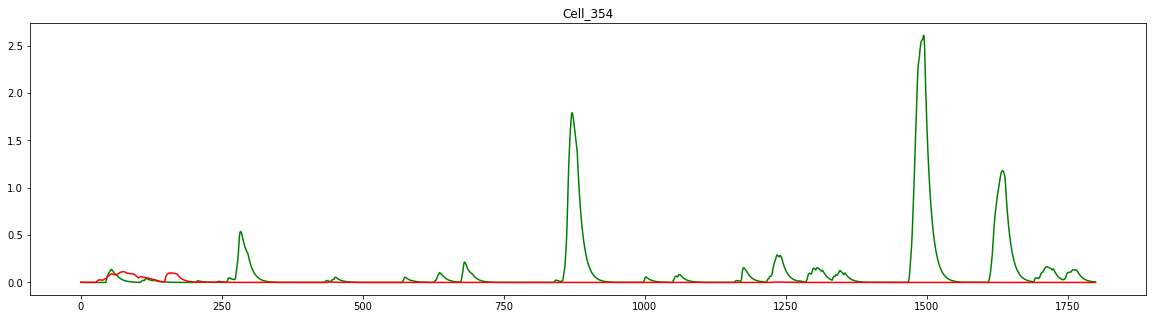

Cell_354-WT


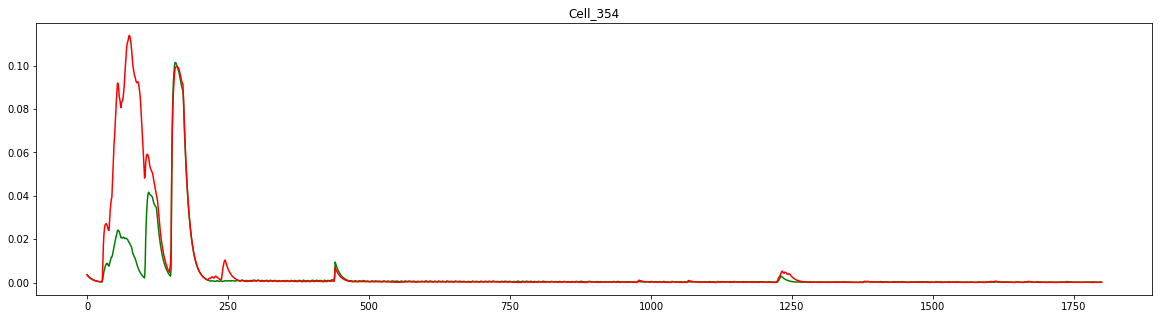

Cell_354-WT_Rya


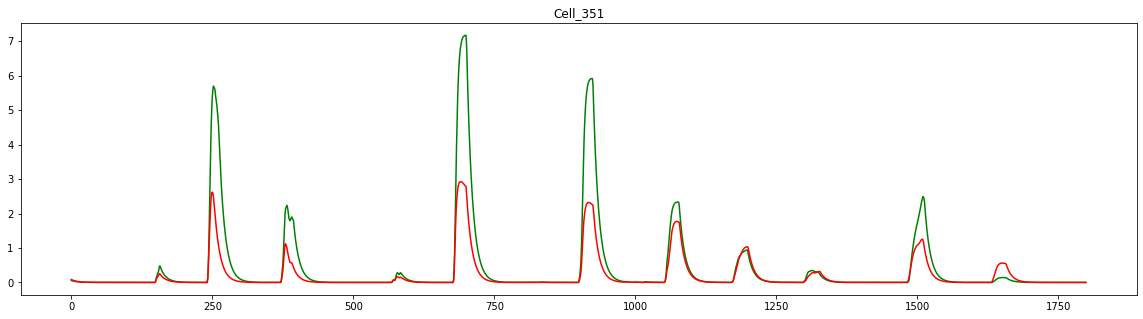

Cell_351-WT


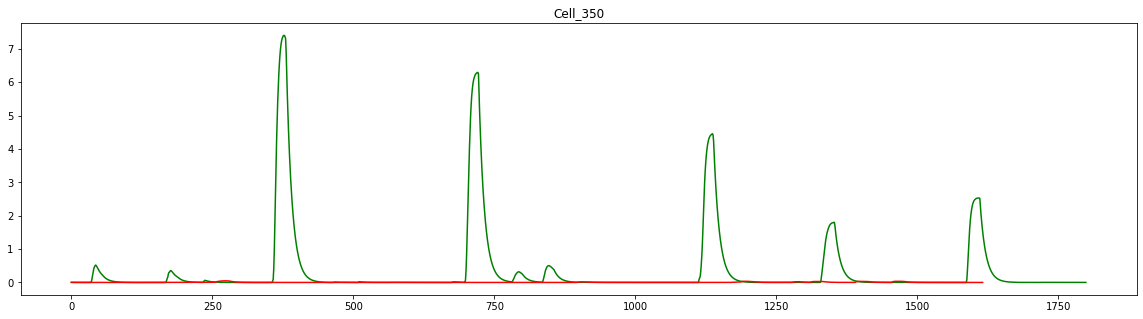

Cell_350-WT


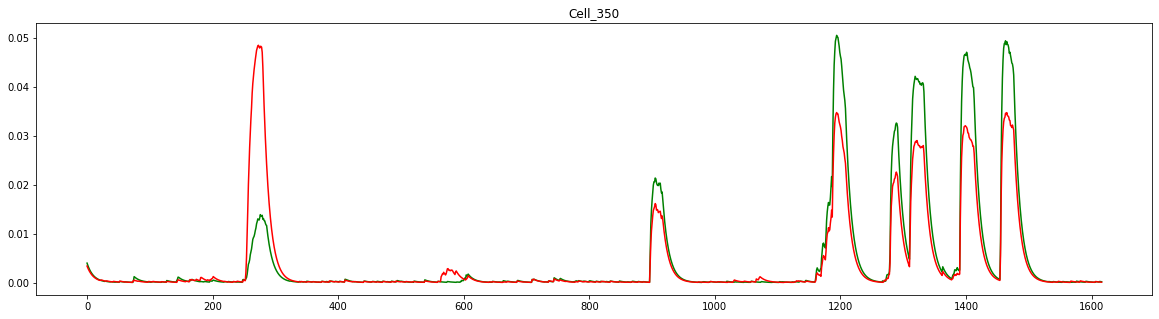

Cell_350-WT_Rya


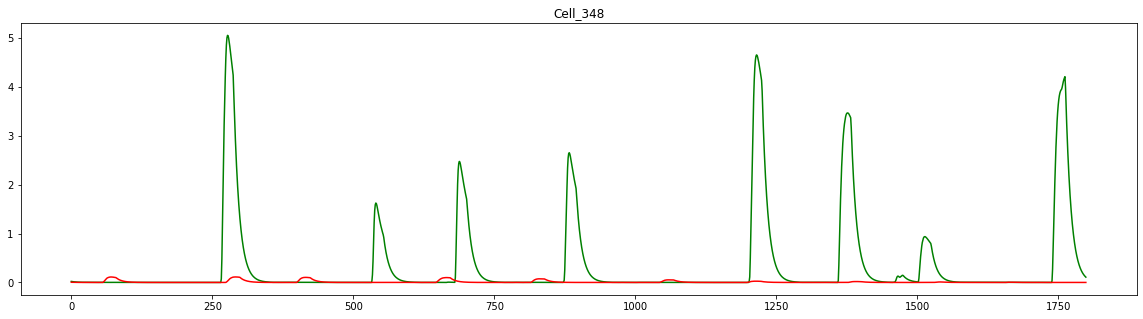

Cell_348-WT


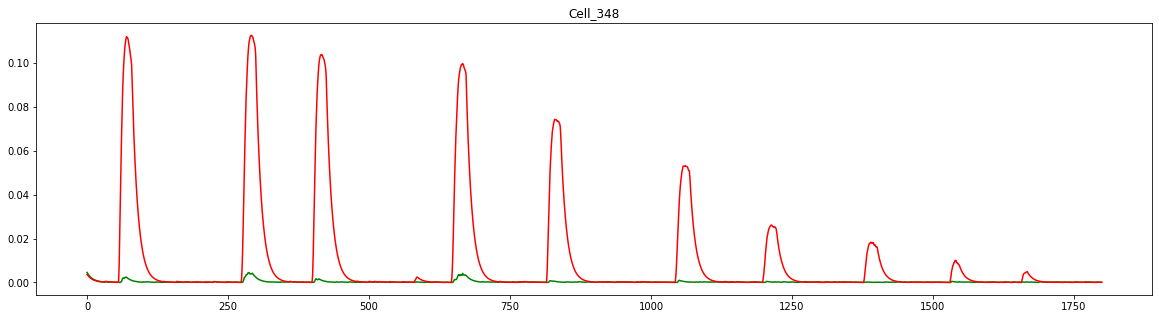

Cell_348-WT_Rya


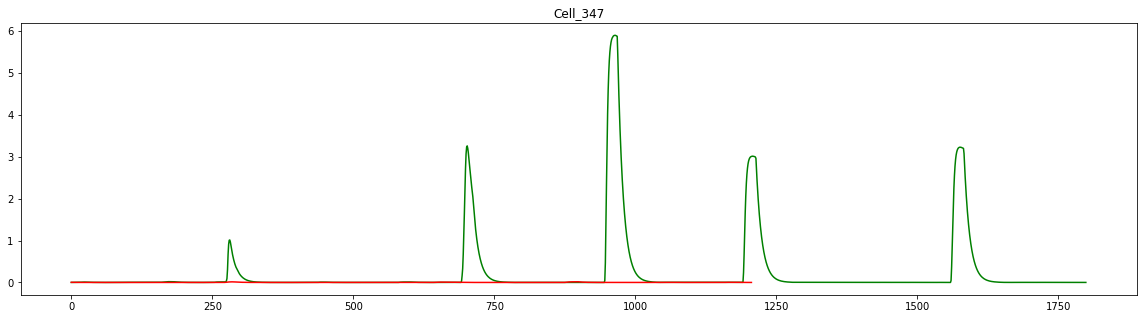

Cell_347-WT


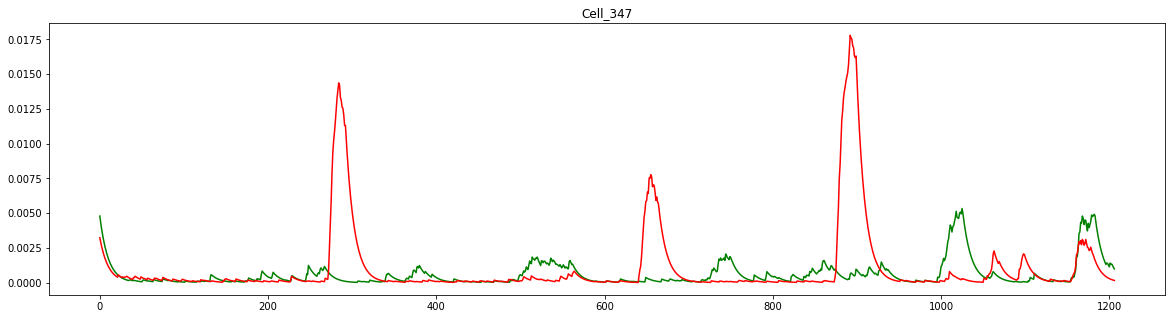

Cell_347-WT_Rya


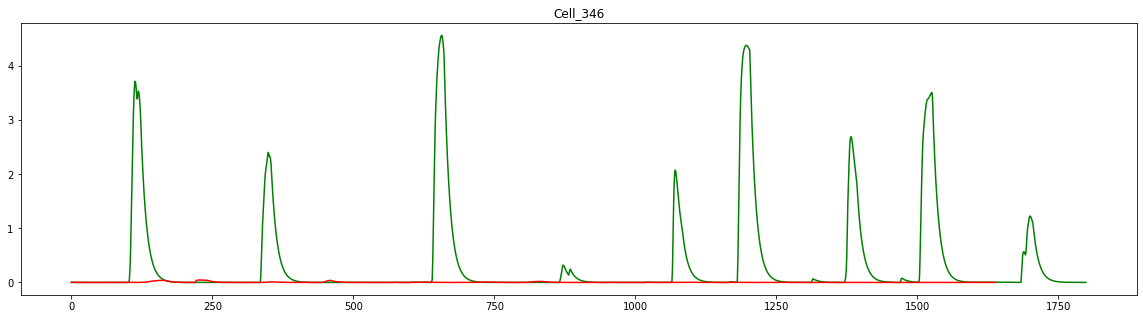

Cell_346-WT


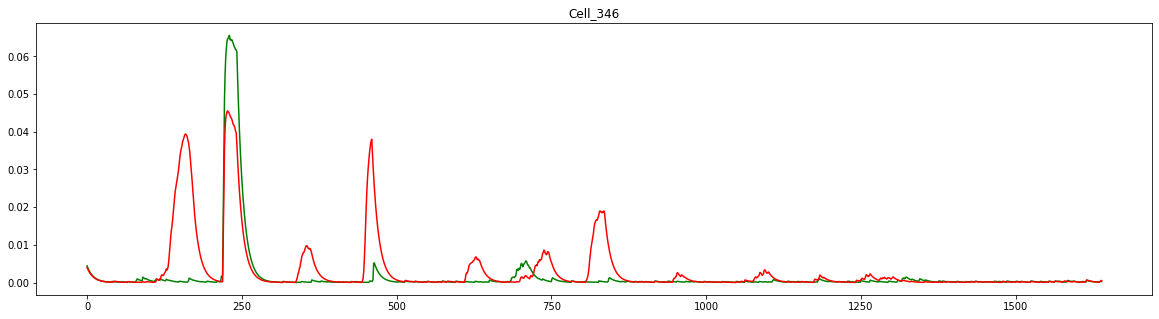

Cell_346-WT_Rya


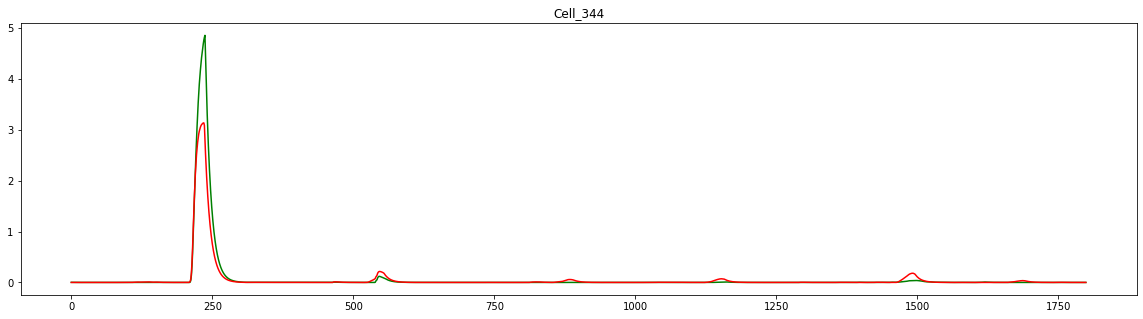

Cell_344-WT


In [78]:
WT_Soma_Threshold = {}
WT_Dendrite_Threshold = {}

WT_Stats = pd.DataFrame()
WT_Shared_Peaks = pd.DataFrame()
WT_GCaMP = pd.DataFrame()
WT_RCaMP = pd.DataFrame()

WT_GTrace = pd.DataFrame()
WT_RTrace = pd.DataFrame()

WT_GDFF = pd.DataFrame()
WT_RDFF = pd.DataFrame()

for cell in WT_Somas:
    dendrites  = next(dend for dend in WT_Dendrites if (cell[:len(cell) - cell[::-1].index('_')]) in dend)
    
    rcamp = np.transpose(np.array(pd.read_csv(os.path.join(DATA_DIRECTORY, dendrites), sep=',',header=None)))
    gcamp = np.transpose(np.array(pd.read_csv(os.path.join(DATA_DIRECTORY, cell), sep=',',header=None)))
    rcamp = rcamp[0]
    gcamp = gcamp[0]

    # Calculate df/f and perform NND
    dffG = deltaFOverF0(gcamp, HZ)
    dffG = nndSmooth(dffG, HZ, tau=1)

    dffR = deltaFOverF0(rcamp, HZ)
    dffR = nndSmooth(dffR, HZ, tau=1)
    if len(cell)==20:
        WT_Soma_Threshold[cell[:11]] = peakThreshold(dffG)
        WT_Dendrite_Threshold[cell[:11]] = peakThreshold(dffR)

    plt.plot(dffG, color='green')
    plt.plot(dffR, color="red")
    plt.title(cell[:8])
    plt.show()
    
    WT_RDFF = WT_RDFF.append(pd.Series([cell, dffR], name=cell))
    WT_GDFF = WT_GDFF.append(pd.Series([cell, dffG], name=cell))
    
    cell_stats, peak_data, gcamp_peak_data, rcamp_peak_data= signal_analysis(cell, dffG, dffR, gcamp, rcamp, WT_Soma_Threshold, WT_Dendrite_Threshold)
    
    WT_Stats = WT_Stats.append(cell_stats, ignore_index=True)
    WT_Shared_Peaks = WT_Shared_Peaks.append(peak_data, ignore_index=True)
    WT_GCaMP = WT_GCaMP.append(gcamp_peak_data, ignore_index=True)
    WT_RCaMP = WT_RCaMP.append(rcamp_peak_data, ignore_index=True)



# <h2> Save Results for WT to CSV

In [ ]:
np.set_printoptions(threshold=8000)
WT_Stats.to_csv("WT_Stats.csv", index=False)
WT_Shared_Peaks.to_csv("WT_Shared_Peaks.csv", index=False)
WT_GCaMP.to_csv("WT_Soma.csv", index=False)
WT_RCaMP.to_csv("WT_Dendrites.csv", index=False)

WT_RTrace.to_csv("WT_Dendrite_Trace.csv", index=False)
WT_GTrace.to_csv("WT_Soma_Trace.csv", index=False)
WT_RDFF.to_csv("WT_Dendrite.csv", index=False)
WT_GDFF.to_csv("WT_Soma.csv", index=False)

np.set_printoptions(threshold=10)

# <h2> Display Results for WT

In [79]:
display(WT_Stats)
display(WT_Shared_Peaks)
display(WT_GCaMP)
display(WT_RCaMP)

,Cell ID,GCaMP Peaks,RCaMP Peaks,Shared Peaks,GCaMP Percent Shared,RCaMP Percent Shared,Experiment Length (s),Drug Application,Iono GCaMP Max,Iono GCaMP Dif,Iono RCaMP Max,Iono RCaMP Dif,RCaMP Total Area,GCaMP Total Area,Prominence Ratio Mean,Prominence Ratio SEM
0,Cell_354-WT,18,7,3,0.166667,0.428571,180.0,NaN,NaN,NaN,NaN,NaN,10.638570,196.159480,9.803663,8.826970
1,Cell_354-WT_Rya,2,7,2,1.000000,0.285714,180.0,NaN,NaN,NaN,NaN,NaN,10.638570,5.626475,0.238871,0.158780
2,Cell_351-WT,11,11,11,1.000000,1.000000,180.0,NaN,NaN,NaN,NaN,NaN,357.431385,722.570741,NaN,NaN
3,Cell_350-WT,9,10,0,NaN,NaN,180.0,NaN,NaN,NaN,NaN,NaN,6.375797,641.245083,0.000000,0.000000
4,Cell_350-WT_Rya,0,10,0,NaN,NaN,161.7,NaN,NaN,NaN,NaN,NaN,6.375797,7.338571,0.000000,0.000000
5,Cell_348-WT,9,11,3,0.333333,0.272727,180.0,NaN,NaN,NaN,NaN,NaN,17.356858,631.626128,5728.480942,5700.097301
6,Cell_348-WT_Rya,0,11,0,NaN,NaN,180.0,NaN,NaN,NaN,NaN,NaN,17.356858,0.583598,0.000000,0.000000
7,Cell_347-WT,5,9,1,0.200000,0.111111,180.0,NaN,NaN,NaN,NaN,NaN,1.267426,424.972443,7.170059,7.170059
8,Cell_347-WT_Rya,0,9,0,NaN,NaN,120.7,NaN,NaN,NaN,NaN,NaN,1.267426,0.745131,0.000000,0.000000
9,Cell_346-WT,11,12,2,0.181818,0.166667,180.0,NaN,NaN,NaN,NaN,NaN,5.050816,606.360019,221.757890,199.288955


,Cell ID,Dendrites Area,Dendrites Loc,Dendrites Prominence,Dendrites Start,Dendrites Start 10% Max,Dendrites Width,Peak Time Diff (S-D),Promicence Ratio (S/D),Soma Area,...,Soma Start,Soma Start 10% Max,Soma Width,Start Difference (S-D),Start Difference (S-D) 10% Max,Dendrite Loc,Dendrite Prominence,Dendrite Start,Dendrite Width,RCaMP Area
0,Cell_354-WT,[],107.0,0.059149,29.359320,-34.612092,7.764068,900.0,0.169225,0.195326,...,-15.214738,-303.653525,13.121474,0.364259,-1.880414,NaN,NaN,NaN,NaN,NaN
1,Cell_354-WT,[],440.0,0.006883,368.737112,231.622363,7.126289,1100.0,5.925730,0.274344,...,318.803755,36.447655,13.219624,0.490666,-0.961747,NaN,NaN,NaN,NaN,NaN
2,Cell_354-WT,0.025291,1233.0,0.005257,1008.905823,819.860938,22.409418,200.0,62.530684,2.208420,...,1021.736743,763.968878,21.326326,0.308309,-0.378921,NaN,NaN,NaN,NaN,NaN
3,Cell_354-WT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,75.0,0.114022,-459.004145,53.400414,2.991930
4,Cell_354-WT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,228.0,0.002937,155.311790,7.268821,0.016785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,Cell_344-WT,1.57405,547.0,0.215434,350.545866,89.105229,19.645413,-100.0,0.552906,0.372053,...,376.180592,187.122223,16.981941,0.166347,0.890170,NaN,NaN,NaN,NaN,NaN
111,Cell_344-WT,2.133272,1491.0,0.180891,1247.173808,986.355281,24.382619,600.0,0.242520,0.707040,...,1166.402568,798.622909,33.059743,-0.267712,-1.337324,NaN,NaN,NaN,NaN,NaN
112,Cell_344-WT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,1153.0,0.071616,909.687130,24.331287,0.896315
113,Cell_344-WT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,883.0,0.057792,656.266227,22.673377,0.615861


,Cell ID,Soma Area,Soma Loc,Soma Prominence,Soma Start,Soma Width
0,Cell_354-WT,1.203286,1346.0,0.125467,1145.835227,20.016477
1,Cell_354-WT,36.982127,1494.0,2.610713,1257.350579,23.664942
2,Cell_354-WT,0.430504,1175.0,0.155302,1052.101909,12.289809
3,Cell_354-WT,2.092525,1306.0,0.155511,1002.770206,30.322979
4,Cell_354-WT,2.461735,283.0,0.539368,95.184257,18.781574
5,Cell_354-WT,15.164699,1634.0,1.181108,1376.260027,25.773997
6,Cell_354-WT,1.898893,1762.0,0.133814,1528.428978,23.357102
7,Cell_354-WT,0.563644,1061.0,0.084474,890.522619,17.047738
8,Cell_354-WT,12.308825,871.0,1.793030,660.842614,21.015739
9,Cell_354-WT,0.522780,680.0,0.214985,548.430065,13.156993


,Cell ID,RCaMP Area,RCaMP Loc,RCaMP Prominence,RCaMP Start,RCaMP Width
0,Cell_354-WT,2.991930,75.0,0.114022,215.995855,53.400414
1,Cell_354-WT,0.016785,228.0,0.002937,2207.311790,7.268821
2,Cell_354-WT,0.043050,245.0,0.010401,2346.128975,10.387102
3,Cell_354-WT,0.879017,159.0,0.099824,1333.123887,25.687611
4,Cell_354-WT_Rya,0.016785,228.0,0.002937,2207.311790,7.268821
...,...,...,...,...,...,...
84,Cell_346-WT_Rya,0.237311,829.0,0.018979,8008.287987,28.171201
85,Cell_346-WT_Rya,0.690727,159.0,0.039384,1259.005590,33.099441
86,Cell_344-WT,0.896315,1153.0,0.071616,11286.687130,24.331287
87,Cell_344-WT,0.615861,883.0,0.057792,8603.266227,22.673377


# <h> Cycle Through YAC128 Cells to Extract Peak Data

In [ ]:
YAC128_Somas = []
YAC128_Dendrites = []

for cell in YAC128_Cells:
    if 'Soma'in cell:
        YAC128_Somas.append(cell)
    if 'Dendrites' in cell:
        YAC128_Dendrites.append(cell)
YAC128_Somas = YAC128_Somas[::-1]
YAC128_Dendrites = YAC128_Dendrites[::-1]
for cell in YAC128_Somas:
    dendrites  = next(dend for dend in YAC128_Dendrites if cell[:8] in dend)
    print(dendrites)

In [21]:
YAC128_Soma_Threshold = {}
YAC128_Dendrite_Threshold = {}


YAC128_Stats = pd.DataFrame()
YAC128_Shared_Peaks = pd.DataFrame()
YAC128_GCaMP = pd.DataFrame()
YAC128_RCaMP = pd.DataFrame()

YAC128_GTrace = pd.DataFrame()
YAC128_RTrace = pd.DataFrame()

YAC128_GDFF = pd.DataFrame()
YAC128_RDFF = pd.DataFrame()
for cell in YAC128_Somas:
    dendrites  = next(dend for dend in YAC128_Dendrites if (cell[:len(cell) - cell[::-1].index('_')]) in dend)
    rcamp = np.transpose(np.array(pd.read_csv(os.path.join(DATA_DIRECTORY, dendrites), sep=',',header=None)))
    gcamp = np.transpose(np.array(pd.read_csv(os.path.join(DATA_DIRECTORY, cell), sep=',',header=None)))
    rcamp = rcamp[0]
    gcamp = gcamp[0]
    
    YAC128_RTrace = YAC128_RTrace.append(pd.Series([cell, rcamp], name=cell))
    YAC128_GTrace = YAC128_GTrace.append(pd.Series([cell, gcamp], name=cell))   


    # Calculate df/f and perform NND
    dffG = deltaFOverF0(gcamp, HZ)
    dffG = nndSmooth(dffG, HZ, tau=1)
    dffR = deltaFOverF0(rcamp, HZ)
    dffR = nndSmooth(dffR, HZ, tau=1)
    if len(cell)==24:
        YAC128_Soma_Threshold[cell[:11]] = peakThreshold(dffG)
        YAC128_Dendrite_Threshold[cell[:11]] = peakThreshold(dffR)   
    
    YAC128_RDFF = YAC128_RDFF.append(pd.Series([cell, dffR], name=cell))
    YAC128_GDFF = YAC128_GDFF.append(pd.Series([cell, dffG], name=cell))
    
    
    cell_stats, peak_data, gcamp_peak_data, rcamp_peak_data = signal_analysis(cell, dffG, dffR, gcamp, rcamp,YAC128_Soma_Threshold, YAC128_Dendrite_Threshold)
    
    
    YAC128_Stats = YAC128_Stats.append(cell_stats, ignore_index=True)
    YAC128_Shared_Peaks = YAC128_Shared_Peaks.append(peak_data, ignore_index=True)
    YAC128_GCaMP = YAC128_GCaMP.append(gcamp_peak_data, ignore_index=True)
    YAC128_RCaMP = YAC128_RCaMP.append(rcamp_peak_data, ignore_index=True)


NameError: name 'YAC128_Somas' is not defined

# <h2> Save Results for YAC128 to CSV

In [ ]:
np.set_printoptions(threshold=8000)
YAC128_Stats.to_csv("YAC128_Stats.csv", index=False)
YAC128_Shared_Peaks.to_csv("YAC128_Shared_Peaks.csv", index=False)
YAC128_GCaMP.to_csv("YAC128_Soma.csv", index=False)
YAC128_RCaMP.to_csv("YAC128_Dendrite.csv", index=False)

YAC128_RTrace.to_csv("YAC128_Dendrite_Trace.csv", index=False)
YAC128_GTrace.to_csv("YAC128_Soma_Trace.csv", index=False)
YAC128_RDFF.to_csv("YAC128_Dendrite_DFF.csv", index=False)
YAC128_GDFF.to_csv("YAC128_Soma_DFF.csv", index=False)

np.set_printoptions(threshold=10)

# <h2> Display Results for YAC128

In [ ]:
display(YAC128_Stats)
display(YAC128_Shared_Peaks)
display(YAC128_GCaMP)
display(YAC128_RCaMP)
